# Table of Contents
* [Introduction](#Introduction)
* [Description](#Description)
* [Project](#Project)
    * [Gravity](#Gravity)
    * [Galaxies](#Galaxies)
    * [Integration](#Integration)

## Introduction

The goal of this project is to simulate gravitational N-body systems. N-body systems are any system where more than two bodies interact. For these systems there is no analytical solution, so it makes it the perfect system to integrate computationally. 

In this project we will examine the properties of galaxies and some emergent dynamics that they exhibit.

## Description

Spiral galaxy arms are an enigma all to themselves. These gorgeous structures are so captivating to look at that we often forget that they are made of millions of stars that are orbiting the galactic center. But stopping to think begs us to ask; how exactly are spiral arms formed?

The prevailing theory is that these arms are formed as stars get stopped in galactic traffic jams. When stars bunch together, there is no force that pushes them apart, gravity only pulls them together. And so a small band of stars that are slightly denser than the rest of the galaxy becomes a larger band of stars which becomes larger still until an arm appears. The stars continue to orbit the galactic center but slow down in the band due to the larger gravitational forces there from other stars. 

## Project

To examine these delicate and fascinating structures, we must create a graviational force in our model as well as galaxies. 

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mplEasyAnimate import animation
from tqdm import tqdm
import pandas as pd
import numba

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Gravity

In order to simulate these galaxies, we need to add force to our simulation. The only force at work on these giant length scales is the gravitational force, so our model becomes very simple. The gravitational force is 

$$ F_{grav} = \frac{G m_1 m_2}{r^2} \hat{r}$$

We simply need the two masses, the distance between them and the vector that points from mass 1 to mass 2.

In [3]:
# @numba.jit(nopython=True)

def get_force(y0,star,m,t):        
    
    x = y0[0]
    y = y0[1]
    z = y0[2]
    vx = y0[3]
    vy = y0[4]
    vz = y0[5]
    
    
    dydt = np.zeros(6)

    # constants
    G = 6.67408e-11
    
    # get distance and angle between two points
    r = np.array([x-star.x,y-star.y,z-star.z])
    dist = np.sqrt((x-star.x)**2+(y-star.y)**2+(z-star.z)**2)
    rhat = r/dist

    # force
    F = -(G*m*star.m)/(dist**2)

    Fv = [F*rhat[0],F*rhat[1],F*rhat[2]]
    
    a = [Fv[0]/m,Fv[1]/m,Fv[2]/m]
    
    dydt[0] = vx
    dydt[1] = vy
    dydt[2] = vz
    dydt[3] = a[0]
    dydt[4] = a[1]
    dydt[5] = a[2]

    return dydt

    

In [4]:
class massive_object:
    def __init__(self,m,x,y,z,vx,vy,vz):
        self.m = m
        self.x = x
        self.y = y
        self.z = z
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.xhist = [x]
        self.yhist = [y]
        self.zhist = [z]
        
    def update(self,x,y,z,vx,vy,vz):
        self.xhist.append(x)
        self.yhist.append(y)
        self.zhist.append(z)
        self.x = x
        self.y = y
        self.z = z
        self.vx = vx
        self.vy = vy
        self.vz = vz
        

def RK4(diffeq, obj1, star, t, h):
    """ RK4 method for ODEs:
        Given y0 at t, returns y1 at t+h 
        Computes the next step for obj1"""
    y0 = np.zeros(6)
    y0[0] = obj1.x
    y0[1] = obj1.y
    y0[2] = obj1.z
    y0[3] = obj1.vx
    y0[4] = obj1.vy
    y0[5] = obj1.vz
    
    
    k1 = h*diffeq(y0, star, obj1.m, t)                    # dy/dt at t
    
    k2 = h*diffeq(y0+0.5*k1, star, obj1.m, t + h/2.)      # dy/dt at t+h/2
    
    k3 = h*diffeq(y0+0.5*k2, star, obj1.m, t + h/2.)      # dy/dt at t+h/2
    
    k4 = h*diffeq(y0+k3, star, obj1.m, t + h)             # dy/dt at t+h
    
    return y0 + (k1+k4)/6.0 + (k2+k3)/3.0

def plot_galaxy(galaxy):
    
    fig = plt.figure(figsize=(7,7))
    for star in galaxy:
        plt.scatter(star.x,star.y)
        plt.quiver(star.x,star.y,star.vx,star.vy)
    
    plt.xlim(-5e20,5e20)
    plt.ylim(-5e20,5e20)
    names = ['Fomalhaut','Getorin','Hesperos','Jennisek','Korell','Lystena','Ophiuchu','Pallas','Sarip','Zoranel']
    r = names[np.random.randint(0,9)]
    plt.title(r)
        
    return fig

def plot_galaxy_3D(galaxy):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    for star in galaxy:
        ax.scatter(star.x, star.y, star.z)
        ax.quiver(star.x, star.y, star.z, star.vx, star.vy, star.vz, normalize=True)
        
    ax.set_xlim(-5e20,5e20)
    ax.set_ylim(-5e20,5e20)
    ax.set_zlim(-5e20,5e20)
    
    names = ['Fomalhaut','Cil','Getorin','Hesperos','Jennisek','Korell','Lystena','Ophiuchu','Pallas','Sarip','Zoranel','Mandross','Radole','Terel']
    r = names[np.random.randint(0,len(names))]
    ax.set_title(r)
    
    return fig

def plot_trails(galaxy):
    
    fig = plt.figure(figsize=(7,7))
    for star in galaxy:
        plt.plot(star.xhist,star.yhist)

    plt.xlim(-5e20,5e20)
    plt.ylim(-5e20,5e20)

    
    return fig

## Galaxies

Now we have to make the galaxy that we will evolve through time. We are building these galaxies using a normal distribution to describe where the stars are radially located around the center of the galaxy. This is not exactly like nature but it is close enough for our purposes. We then uniformly distribute the stars around the galaxy, and uniformly distribute them in the z axis too for a thin disk.

In [5]:
def make_galaxy(N,R,x,y,z):
    G = 6.67408e-11
    
    stars = []
    M = 4e36
    stars.append(massive_object(M,x,y,z,0,0,0))
    
    np.random.seed()
    
    for i in range(0,N-1):
        r = np.random.normal(.33*R,.2*R)
        theta = np.random.uniform(0,2*np.pi)
        
        xi = r*np.cos(theta)
        yi = r*np.sin(theta)
        zi = np.random.uniform(0,1e18)
        
        vx = .5*np.sqrt(G*M/r)*np.cos(theta-np.pi/2)
        vy = .5*np.sqrt(G*M/r)*np.sin(theta-np.pi/2)
        vz = 0
        
        m = np.random.normal(1e30,1e3)
        
        stars.append(massive_object(m,xi,yi,zi,vx,vy,vz))
    
    return stars

Now we can make our galaxy! One fun piece of code I added names each galaxy so when we plot them we have a personal attachment to them.

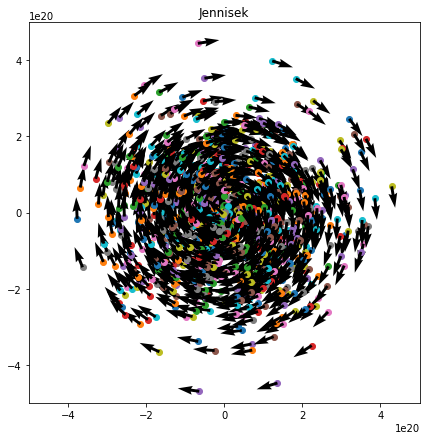

In [6]:
N = 1000
galaxy = make_galaxy(N,5e20,0,0,0)
fig = plot_galaxy(galaxy)

## Integration

Now we must propagate our galaxies through time. This is the longest and most computationally expensive part of the project. To measure the force between each star in the galaxy is an extremely slow process, especially in python where each line is run on it's own instead of being compiled. 

An easy fix for this would be simply to have the stars only be affected by the massive black hole at the center of the galaxy, which would cut down the number of calculations the computer had to do. But then we would not be able to see the spiral arms forming. Regardless, I've created a function called ```propagate_easy``` so we could do this anyway.

In [7]:
def propagate_galaxy(galaxy,t_i,t_f,dt):
    
    time = np.arange(t_i,t_f,dt)
    
    for t in tqdm(time):
        for star1 in galaxy:
            for star2 in galaxy:
                if star1 != star2:
                    star1.update(*RK4(get_force,star1,star2,t,dt))
                    
# def propagate_easy(galaxy,t_i,t_f,dt):
#     time = np.arange(t_i,t_f,dt)
    
#     for t in tqdm(time):
#         for star1 in galaxy[1:]:
#             star1.update(*RK4(get_force,star1,galaxy[0],t,dt))

In [9]:
N = 10
galaxy1 = make_galaxy(N,5e20,0,0,0)
propagate_galaxy(galaxy1,0,3e17,1e12)


  2%|▏         | 5842/300000 [00:29<24:32, 199.83it/s]


  4%|▍         | 11633/300000 [00:58<24:01, 200.07it/s]


  6%|▌         | 17426/300000 [01:26<23:23, 201.35it/s]


  8%|▊         | 23222/300000 [01:54<22:49, 202.10it/s]


 10%|▉         | 28962/300000 [02:23<22:23, 201.79it/s]


 12%|█▏        | 34747/300000 [02:51<21:52, 202.13it/s]


 14%|█▎        | 40530/300000 [03:20<21:23, 202.23it/s]


 15%|█▌        | 46265/300000 [03:48<20:55, 202.07it/s]


 17%|█▋        | 52061/300000 [04:17<20:25, 202.31it/s]


 19%|█▉        | 57849/300000 [04:45<19:55, 202.50it/s]


 21%|██        | 63645/300000 [05:14<19:26, 202.67it/s]


 23%|██▎       | 69441/300000 [05:42<18:56, 202.80it/s]


 25%|██▌       | 75234/300000 [06:10<18:27, 202.90it/s]


 27%|██▋       | 81025/300000 [06:39<17:58, 202.96it/s]


 29%|██▉       | 86821/300000 [07:07<17:29, 203.06it/s]


 31%|███       | 92617/300000 [07:35<17:00, 203.16it/s]


 33%|███▎      | 98413/300000 [08:04<16:31, 203.22it/s]


 35%|███▍      | 104147/300000 [08:32<16:03, 203.29it/s]


 37%|███▋      | 109857/300000 [09:00<15:35, 203.32it/s]


 39%|███▊      | 115569/300000 [09:28<15:06, 203.38it/s]


 40%|████      | 121281/300000 [09:56<14:38, 203.42it/s]


 42%|████▏     | 126993/300000 [10:24<14:10, 203.44it/s]


 44%|████▍     | 132705/300000 [10:52<13:42, 203.49it/s]


 46%|████▌     | 138417/300000 [11:20<13:13, 203.51it/s]


 48%|████▊     | 144127/300000 [11:48<12:45, 203.53it/s]


 50%|████▉     | 149837/300000 [12:16<12:17, 203.54it/s]


 52%|█████▏    | 155549/300000 [12:44<11:49, 203.56it/s]


 54%|█████▎    | 161245/300000 [13:12<11:21, 203.55it/s]


 56%|█████▌    | 166957/300000 [13:40<10:53, 203.57it/s]


 58%|█████▊    | 172669/300000 [14:08<10:25, 203.58it/s]


 59%|█████▉    | 178381/300000 [14:36<09:57, 203.60it/s]


 61%|██████▏   | 184092/300000 [15:04<09:29, 203.62it/s]


 63%|██████▎   | 189804/300000 [15:32<09:01, 203.65it/s]


 65%|██████▌   | 195516/300000 [16:00<08:33, 203.66it/s]


 67%|██████▋   | 201227/300000 [16:28<08:04, 203.67it/s]


 69%|██████▉   | 206938/300000 [16:56<07:36, 203.68it/s]


 71%|███████   | 212650/300000 [17:23<07:08, 203.69it/s]


 73%|███████▎  | 218362/300000 [17:52<06:40, 203.69it/s]


 75%|███████▍  | 224072/300000 [18:20<06:12, 203.70it/s]


 77%|███████▋  | 229784/300000 [18:47<05:44, 203.72it/s]


 78%|███████▊  | 235495/300000 [19:15<05:16, 203.73it/s]


 80%|████████  | 241207/300000 [19:43<04:48, 203.75it/s]


 82%|████████▏ | 246919/300000 [20:11<04:20, 203.75it/s]


 84%|████████▍ | 252631/300000 [20:39<03:52, 203.76it/s]


 86%|████████▌ | 258343/300000 [21:07<03:24, 203.77it/s]


 88%|████████▊ | 264055/300000 [21:35<02:56, 203.78it/s]


 90%|████████▉ | 269767/300000 [22:03<02:28, 203.78it/s]


 92%|█████████▏| 275479/300000 [22:31<02:00, 203.79it/s]


 94%|█████████▎| 281172/300000 [22:59<01:32, 203.78it/s]


 96%|█████████▌| 286878/300000 [23:27<01:04, 203.78it/s]


 98%|█████████▊| 292590/300000 [23:55<00:36, 203.79it/s]


 99%|█████████▉| 298300/300000 [24:23<00:08, 203.79it/s]


100%|██████████| 300000/300000 [24:32<00:00, 203.79it/s]

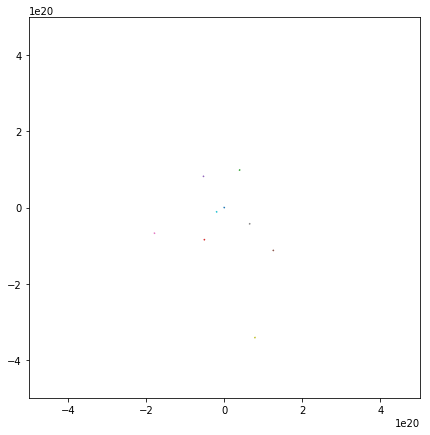

In [15]:
fig = plot_trails(galaxy1)

The problem with using python for large n-body simulations is that it is very slow. I have tried to use python numba to speed it up, but I have not been successful. I think if I had more time to work on it I could implement numba, but unfortunately I have run out of time. 

For future work on this project and others I will attempt to make numba work.

This project is very interesting to me as I am fascinated by orbital dynamics and navigation in space. I want to use this code to simulate the trajectories of interplanetary probes in the future.